In [1]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
X, y = mnist['data'], mnist['target']
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [3]:
import numpy as np
y = y.astype(np.uint8)

In [4]:
X[0].reshape(28,28)
X[0].shape

(784,)

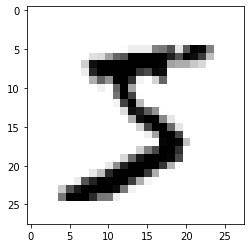

In [5]:
import matplotlib.pyplot as plt
some_digit = X[0]
reshaped_some_digit = some_digit.reshape(28,28)

plt.imshow(reshaped_some_digit, cmap='binary')
plt.show()

In [6]:
# splitting the data into train and test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
# creating a classifier for 5 or not 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
# checking the classes
np.unique(y_train_5)

array([False,  True])

In [9]:
# starting with SGD binary classifier
# reason is its good with large dataset
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

array([ True])

In [10]:
# validating the SGDClassifier
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# adding confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_predict = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_predict)

array([[53892,   687],
       [ 1891,  3530]])

In [12]:
# lets try another classifier svm.svc

# from sklearn import svm
# clf = svm.SVC(C=200,kernel='rbf',gamma=0.01,cache_size=8000,probability=False)
# clf.fit(X_train, y_train_5)
# clf.predict([some_digit])

In [13]:
# using another classifier
from sklearn.base import BaseEstimator
class Not5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

not5_clf = Not5Classifier()
cross_val_score(not5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

In [14]:
# precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_predict)

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

In [16]:
# computing the f1 score
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_predict)

0.7325171197343846

In [17]:
# using decision function to get each instance (decision scores)
y_scores = sgd_clf.decision_function([some_digit])
y_scores
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [18]:
# increasing the threshold
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

## the increase in threshold decreases the threshold. 
## Now the question is what threshold value to use?

In [19]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

In [20]:
# now use the above values with the precision_recall_curve()
from sklearn.metrics import precision_recall_curve
precisions, recalls, threshold = precision_recall_curve(y_train_5, y_scores)

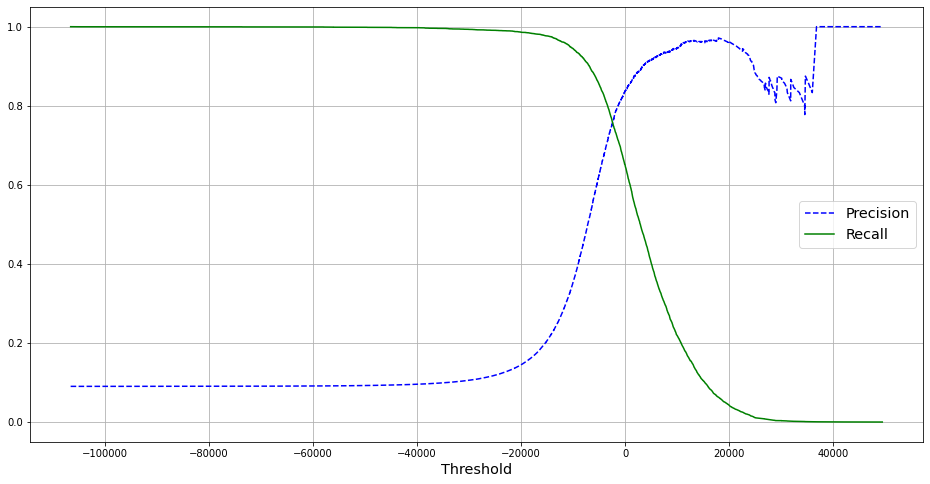

In [21]:
# use matplotlib to plot the graph
def plotVsThreshold(precisions, recalls, threshold):
    plt.figure(figsize=(16,8))
    plt.plot(threshold, precisions[:-1], "b--", label="Precision")
    plt.plot(threshold, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold", fontsize='x-large')
    plt.grid(True)
plotVsThreshold(precisions, recalls, threshold)
plt.legend(loc='center right',fontsize='x-large')
plt.show()

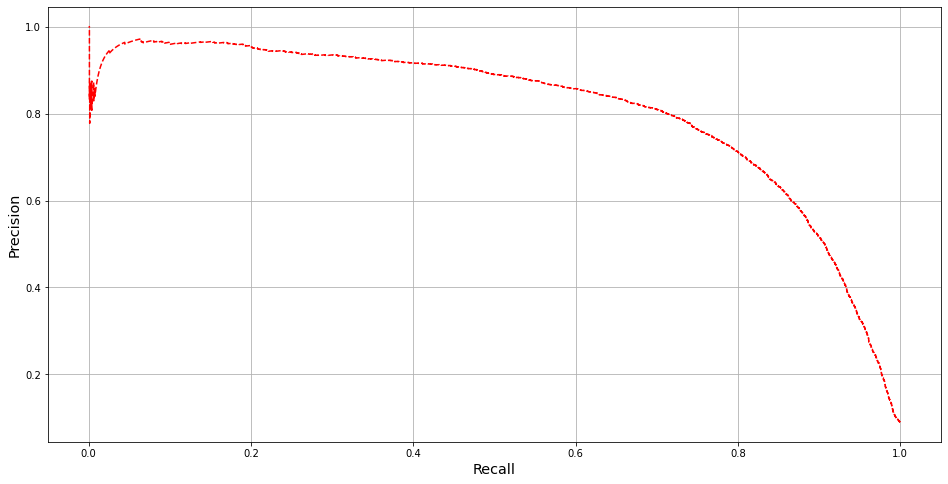

In [22]:
# plotting precision vs recall
def precisionVsRecall(precision, recall):
    plt.figure(figsize=(16,8))
    plt.plot(recall, precision, 'r--')
    plt.xlabel("Recall", fontsize='x-large')
    plt.ylabel("Precision", fontsize='x-large')
    plt.grid(True)

precisionVsRecall(precisions, recalls)
plt.show()

In [23]:
# lets say we want 90% precision hence take all the values before the drop in the second graph
threshold_90_precision = threshold[np.argmax(precisions >= 0.90)]
threshold_90_precision

3370.0194991439557

In [24]:
# instead of calling predict function on the train set we use
y_train_pred_90_precision = (y_scores >= threshold_90_precision)
y_train_pred_90_precision

array([False, False, False, ...,  True, False, False])

In [25]:
precision_score(y_train_5, y_train_pred_90_precision)

0.9000345901072293

In [26]:
recall_score(y_train_5, y_train_pred_90_precision)

0.4799852425751706

# plotting ROC Curve

In [27]:
from sklearn.metrics import roc_curve
fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

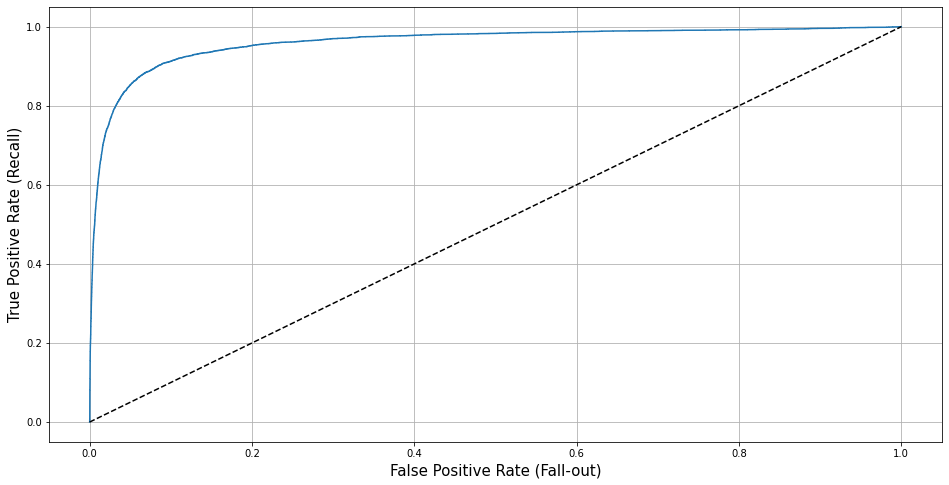

In [28]:
def plotROC(fpr, tpr, label=None):
    plt.figure(figsize=(16,8))
    plt.plot(fpr, tpr, label=label)
    plt.plot([0,1], [0,1], 'k--') # dashed diagonal
    plt.xlabel('False Positive Rate (Fall-out)', fontsize=15)
    plt.ylabel('True Positive Rate (Recall)', fontsize=15)
    plt.grid(True)

plotROC(fpr, tpr)
plt.show()

In [29]:
## plotting the ROC_AUC score and then use RandomForest Classifier
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [30]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(random_state=42)
y_proba_forest = cross_val_predict(rnd_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [31]:
y_scores_forest = y_proba_forest[:,1]
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [32]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

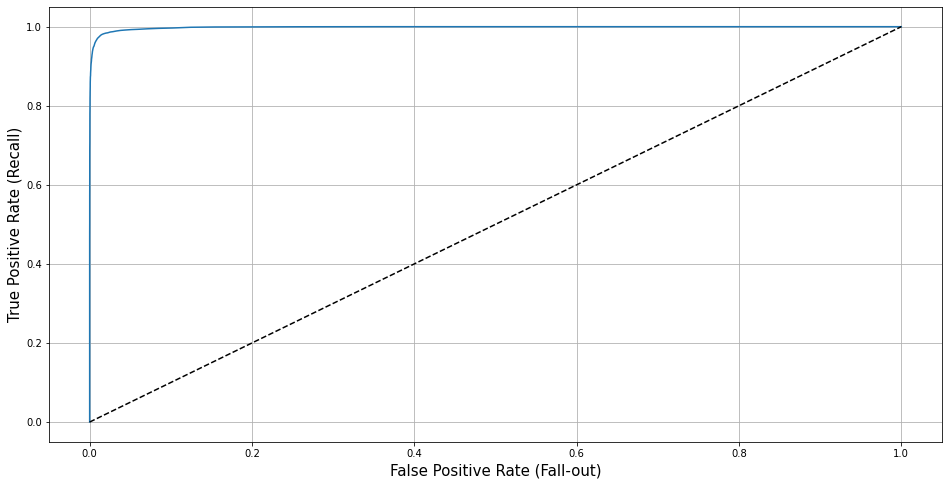

In [33]:
# calling plotRoc
plotROC(fpr_forest, tpr_forest, "Random Forest")

In [34]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [35]:
y_train_pred_forest = cross_val_predict(rnd_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [36]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

## So here we have a classifier with 99% precision and 86.6% recall.

# Multiclass Classification

In [37]:
from sklearn.svm import SVC
svm_svc = SVC()
svm_svc.fit(X_train, y_train)
svm_svc.predict([some_digit])

array([5], dtype=uint8)

In [38]:
# getting the decision_function scores
some_digit_scores = svm_svc.decision_function([some_digit])
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [39]:
np.argmax(some_digit_scores)

5

In [40]:
# time for increasing the scores, so scale the values
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
X_train_scale = scal.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scale, y_train, cv=3, scoring='accuracy') # validating with the sgdClassifier

array([0.8983, 0.891 , 0.9018])

## Error analysis

In [41]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scale, y_train, cv=3)
conf_matr = confusion_matrix(y_train, y_train_pred)
conf_matr

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

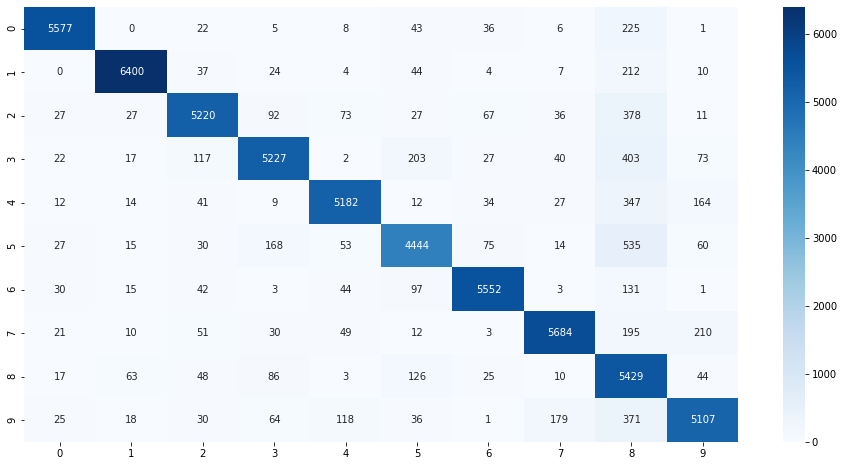

In [48]:
# using sklearn.metrics.plot_confusion_matrix()
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns
# disp = plot_confusion_matrix(sgd_clf, X_train_scale, y_train_pred)
plt.figure(figsize=(16,8))
sns.heatmap(conf_matr, annot=True, cmap='Blues' ,fmt='g')
plt.show()

## Now there are couple of ways you can enhnce this issue between classifing 3 or 5:
    - use scikit-image, pillow or opencv
    - analyze individual errors
    - preprocess again the imgaes that they are well centered